<a href="https://colab.research.google.com/github/nati-curious/EPAM-University-Data-Science-Program/blob/main/linear_regression_TensorFlow_Multilayer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import frameworks and libraries

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import json
import io
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.style.use('ggplot')
%matplotlib inline

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
# global seeds for reproducibility (make the process stable)
tf.random.set_seed(3)

from numpy.random import seed
seed(777)

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper functions

In [ ]:
# Function for a sine and cosine transformation of cyclical features of a train subset
def encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

# Linear Regression with Multilayer Perceptron Model (MLP)

Regression analysis with neural network. For this project, we use the same data as for regression in Sklearn. You can see it [here](https://colab.research.google.com/drive/1cyJYR5FCOy4OeD0nqeXdMFpti9cXSLDU#scrollTo=aONz6FTPTs_o).

## EDA and Data Preparation

[Air Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Air+Quality#) contains 9,358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level, within an Italian city. Data were recorded from March 2004 to February 2005 (one year) representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.

In [ ]:
# Read in a CSV file
data = pd.read_csv('/content/drive/MyDrive/AirQualityUCI.csv', delimiter=';', decimal='.')
data

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 5 elements with ground truth measurements that were provided by a certified analyzer:

CO(GT) - cobalt,\
NMHC(GT) - non metanic hydrocarbons,\
C6H6(GT) - benzene,\
NOx(GT) - total nitrogen oxides,\
NO2(GT) - nitrogen dioxide.

Also we have measurements of:\
T - temperature,\
RH - relative humidity (depends on the temperature of air; on increasing temperature, relative humidity decreases),\
AH - absolute humidity (measure of the actual amount of water vapor (moisture) in the air, regardless of the air's temperature).

Our target is to predict Benzene metrics.

In the dataset there are metrics obtained by sensor:\
PT08.S1(CO),\
PT08.S2(NMHC),\
PT08.S3(NOx),\
PT08.S4(NO2),\
PT08.S5(O3).

We don't have sensor measurement for our target chemical element benzene - C6H6(GT).\
We don't have ground truth measurement for ozone (O3).

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [ ]:
# Check for NA values
data.isna().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [ ]:
data.min()

/var/folders/q5/8bqsl0cn53g4h0r47y4m8r1c0000gn/T/ipykernel_3679/927168777.py:1: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.min()


PT08.S1(CO)     -200.0
NMHC(GT)        -200.0
PT08.S2(NMHC)   -200.0
NOx(GT)         -200.0
PT08.S3(NOx)    -200.0
NO2(GT)         -200.0
PT08.S4(NO2)    -200.0
PT08.S5(O3)     -200.0
Unnamed: 15        NaN
Unnamed: 16        NaN
dtype: float64

In [ ]:
data.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
Unnamed: 15      float64
Unnamed: 16      float64
dtype: object

* Numerical data is propmpted as objects that tells us about messy data.
* 'Unnamed: 15' and 'Unnamed: 16' columns contain only NaN values.
* There is no '-200' values, only '-200.0' (maybe it is misleading description or maybe it is untidy dataset).
* In the dataset description it is said that the dataset contains 9358 instances. CSV contains 9471 samples. I suppose 'additional' rows contains NA values that we can see in the tail of the table.

Let's check an XLSX file.

In [ ]:
uploaded = files.upload()

df = pd.read_excel(io.BytesIO(uploaded.get('AirQualityUCI.xlsx')))
df.head()

Saving AirQualityUCI.xlsx to AirQualityUCI (4).xlsx


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [ ]:
df.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [ ]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

Dataset in the XLSX file contains data in an appropriate format.

In [ ]:
df.min()

Date             2004-03-10 00:00:00
Time                        00:00:00
CO(GT)                        -200.0
PT08.S1(CO)                   -200.0
NMHC(GT)                        -200
C6H6(GT)                      -200.0
PT08.S2(NMHC)                 -200.0
NOx(GT)                       -200.0
PT08.S3(NOx)                  -200.0
NO2(GT)                       -200.0
PT08.S4(NO2)                  -200.0
PT08.S5(O3)                   -200.0
T                             -200.0
RH                            -200.0
AH                            -200.0
dtype: object

In an XLSX file there are more features with minimum values than in a CSV file. We are especially interested in '-200' values that are perhaps strings in CSV file.\
Let's work with the XLSX file because it is more tidy.

In [ ]:
# Check for duplicates
df.duplicated().sum()

0

It seems missing values are tagged not only as -200 but also as -200.0. Let's check how many each column has this type of values.

In [ ]:
df['CO(GT)'].value_counts()

-200.0    1683
 1.0       305
 1.4       279
 1.6       275
 1.5       273
          ... 
 9.9         1
 7.6         1
 9.3         1
 7.0         1
 8.5         1
Name: CO(GT), Length: 97, dtype: int64

In [ ]:
df['PT08.S1(CO)'].value_counts()

-200.000000     366
 1099.500000     12
 954.250000      12
 986.750000      12
 888.000000      11
               ... 
 808.000000       1
 834.333333       1
 891.666667       1
 748.500000       1
 1314.250000      1
Name: PT08.S1(CO), Length: 3246, dtype: int64

In [ ]:
df['NMHC(GT)'].value_counts()

-200    8443
 66       14
 40        9
 29        9
 88        8
        ... 
 422       1
 424       1
 339       1
 445       1
 307       1
Name: NMHC(GT), Length: 430, dtype: int64

In [ ]:
df['C6H6(GT)'].value_counts()

-200.000000    366
 6.849892       13
 10.184263       9
 5.560496        9
 4.045717        9
              ... 
 26.798408       1
 18.833976       1
 21.837693       1
 21.275833       1
 1.307608        1
Name: C6H6(GT), Length: 3773, dtype: int64

In [ ]:
df['PT08.S2(NMHC)'].value_counts()

-200.000000     366
 850.250000      13
 984.500000       9
 791.000000       9
 713.250000       9
               ... 
 1474.000000      1
 1263.500000      1
 1346.666667      1
 1331.500000      1
 528.000000       1
Name: PT08.S2(NMHC), Length: 3773, dtype: int64

In [ ]:
df['NOx(GT)'].value_counts()

-200.0    1639
 65.0       37
 89.0       36
 41.0       36
 57.0       32
          ... 
 450.9       1
 564.7       1
 715.8       1
 794.1       1
 353.3       1
Name: NOx(GT), Length: 2467, dtype: int64

In [ ]:
df['PT08.S3(NOx)'].value_counts()

-200.00     366
 829.50      11
 866.25      10
 683.25      10
 844.50       9
           ... 
 1429.25      1
 1587.25      1
 1056.50      1
 637.25       1
 414.75       1
Name: PT08.S3(NOx), Length: 3519, dtype: int64

In [ ]:
df['NO2(GT)'].value_counts()

-200.0    1642
 97.0       68
 95.0       66
 101.0      65
 114.0      63
          ... 
 290.6       1
 275.9       1
 249.8       1
 251.2       1
 167.7       1
Name: NO2(GT), Length: 1420, dtype: int64

In [ ]:
df['PT08.S4(NO2)'].value_counts()

-200.00     366
 1490.00     10
 1363.00      9
 1479.25      8
 1533.50      8
           ... 
 1123.25      1
 2185.00      1
 2165.50      1
 1370.25      1
 987.00       1
Name: PT08.S4(NO2), Length: 4408, dtype: int64

In [ ]:
df['PT08.S5(O3)'].value_counts()

-200.00     366
 825.75      10
 904.50       8
 779.00       8
 835.50       8
           ... 
 663.75       1
 593.25       1
 610.50       1
 410.00       1
 1269.00      1
Name: PT08.S5(O3), Length: 4679, dtype: int64

In [ ]:
df['T'].value_counts()

-200.000000    366
 23.050000      15
 15.050000      15
 24.000000      13
 20.800000      13
              ... 
 36.849999       1
 36.325001       1
 35.825001       1
 32.150000       1
 28.500000       1
Name: T, Length: 3368, dtype: int64

In [ ]:
df['RH'].value_counts()

-200.000000    366
 47.750000      11
 51.450000       9
 49.675000       8
 55.950000       8
              ... 
 55.474999       1
 61.750000       1
 25.600000       1
 26.350000       1
 18.350000       1
Name: RH, Length: 4903, dtype: int64

In [ ]:
df['AH'].value_counts()

-200.000000    366
 1.471326        2
 0.779770        2
 0.705801        2
 1.320841        2
              ... 
 1.082815        1
 1.011949        1
 0.909946        1
 1.004462        1
 0.502804        1
Name: AH, Length: 8988, dtype: int64

In [ ]:
# Replace '-200' and '-200.0' with NaN for futher work and decisions
df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', \
    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']] \
    = df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', \
    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]. \
    replace([-200, -200.0], np.NaN)
df.isnull().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [ ]:
# Calculate percentage of NA values in C6H6(GT) column
C6H6GT_ratio = df['C6H6(GT)'].isna().sum()/len(df['C6H6(GT)'])
C6H6GT_ratio

0.0391151009939083

In [ ]:
# Remove rows with NA values in a target variable to keep it 0% synthetic
df.drop(df[df['C6H6(GT)'].isna()].index, axis = 0, inplace = True)

In [ ]:
# Drop rows with all NA values (if there are any)
df = df.dropna(how='all')
df.shape

(8991, 15)

There is no rows with all NA values.

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# Calculate percentage of NA values in NMHC(GT) column
NMHC_ratio = df['NMHC(GT)'].isna().sum()/len(df['NMHC(GT)'])
NMHC_ratio

0.9013457902346791

In [ ]:
# Since 90% of NMHC(GT) column's values is NA drop this column
df = df.drop('NMHC(GT)', axis=1)

In [ ]:
# Combine Date and Time columns for further data wrangling
new_df = pd.to_datetime(df.Date.astype(str) + ' ' +df.Time.astype(str))
df.insert(2, 'DateTime', new_df)
df = df.drop(['Date', 'Time'], axis=1)
df.reset_index(drop=True)
df.head()

,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10 19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10 20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10 21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10 22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [ ]:
# Make a copy of a current DataFrame for the part with scaling
df_scaling = df.copy()

Let's change indices of the DataFrame to a Date column to later fill missing values with `time` method of `interpolate` function and divide the data set as Time Series.

In [ ]:
# Make a Date column an index
df.set_index('DateTime', inplace=True)
df.tail()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,
2005-04-04 10:00:00,3.1,1314.25,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250,0.756824
2005-04-04 11:00:00,2.4,1162.50,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725,0.711864
2005-04-04 12:00:00,2.4,1142.00,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350,0.640649
2005-04-04 13:00:00,2.1,1002.50,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550,0.513866
2005-04-04 14:00:00,2.2,1070.75,11.932060,1047.25,265.2,654.00,167.7,1128.50,816.00,28.500,13.125,0.502804


### Multivariate Analysis

#### Feature correlation

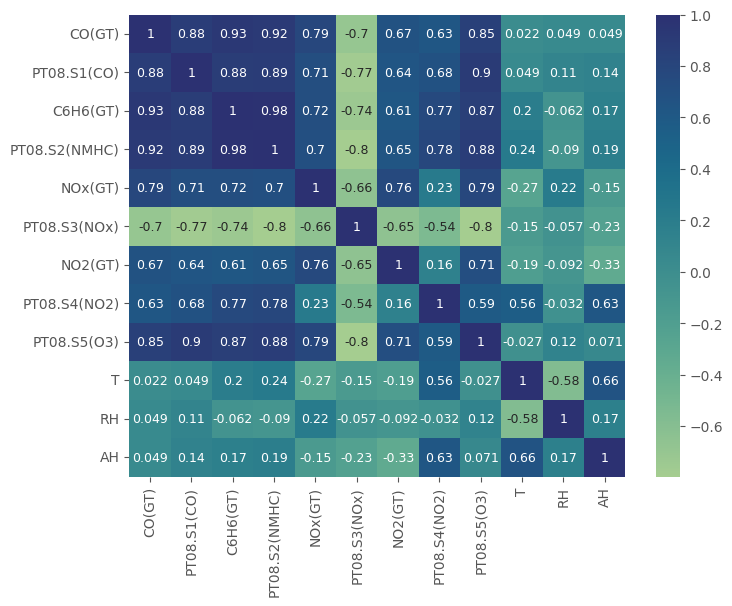

In [ ]:
# Plot heatmap
corr = df.corr()
sns.heatmap(corr, annot=True, annot_kws={"size": 9}, cmap="crest");

The target is most correlated with PT08.S2(NMHC).

 Correlation of all the features except for temperature, relative humidity and absolute humidity are higher than 0.5. Let's keep only features that are higly correlated with a target to avoid noise in the model.

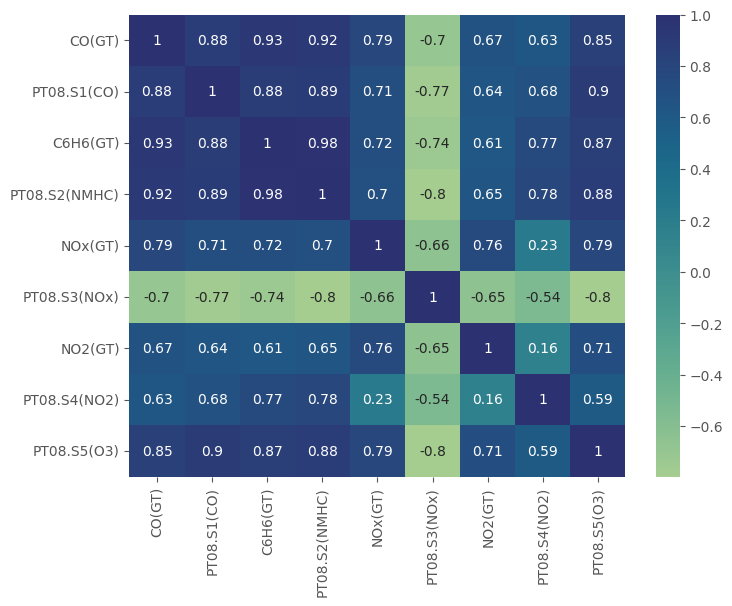

In [ ]:
# Plot heatmap of only strongly correlated features
corr = df.corr()
condition = np.abs(corr['C6H6(GT)']) > 0.5
top_corr = corr.loc[condition, condition]
df_top_corr = df.loc[:, top_corr.columns]
sns.heatmap(top_corr, annot=True, cmap="crest");

#### Pairwise correlation

Pairwise plot of moderately and strongly correlated variables.

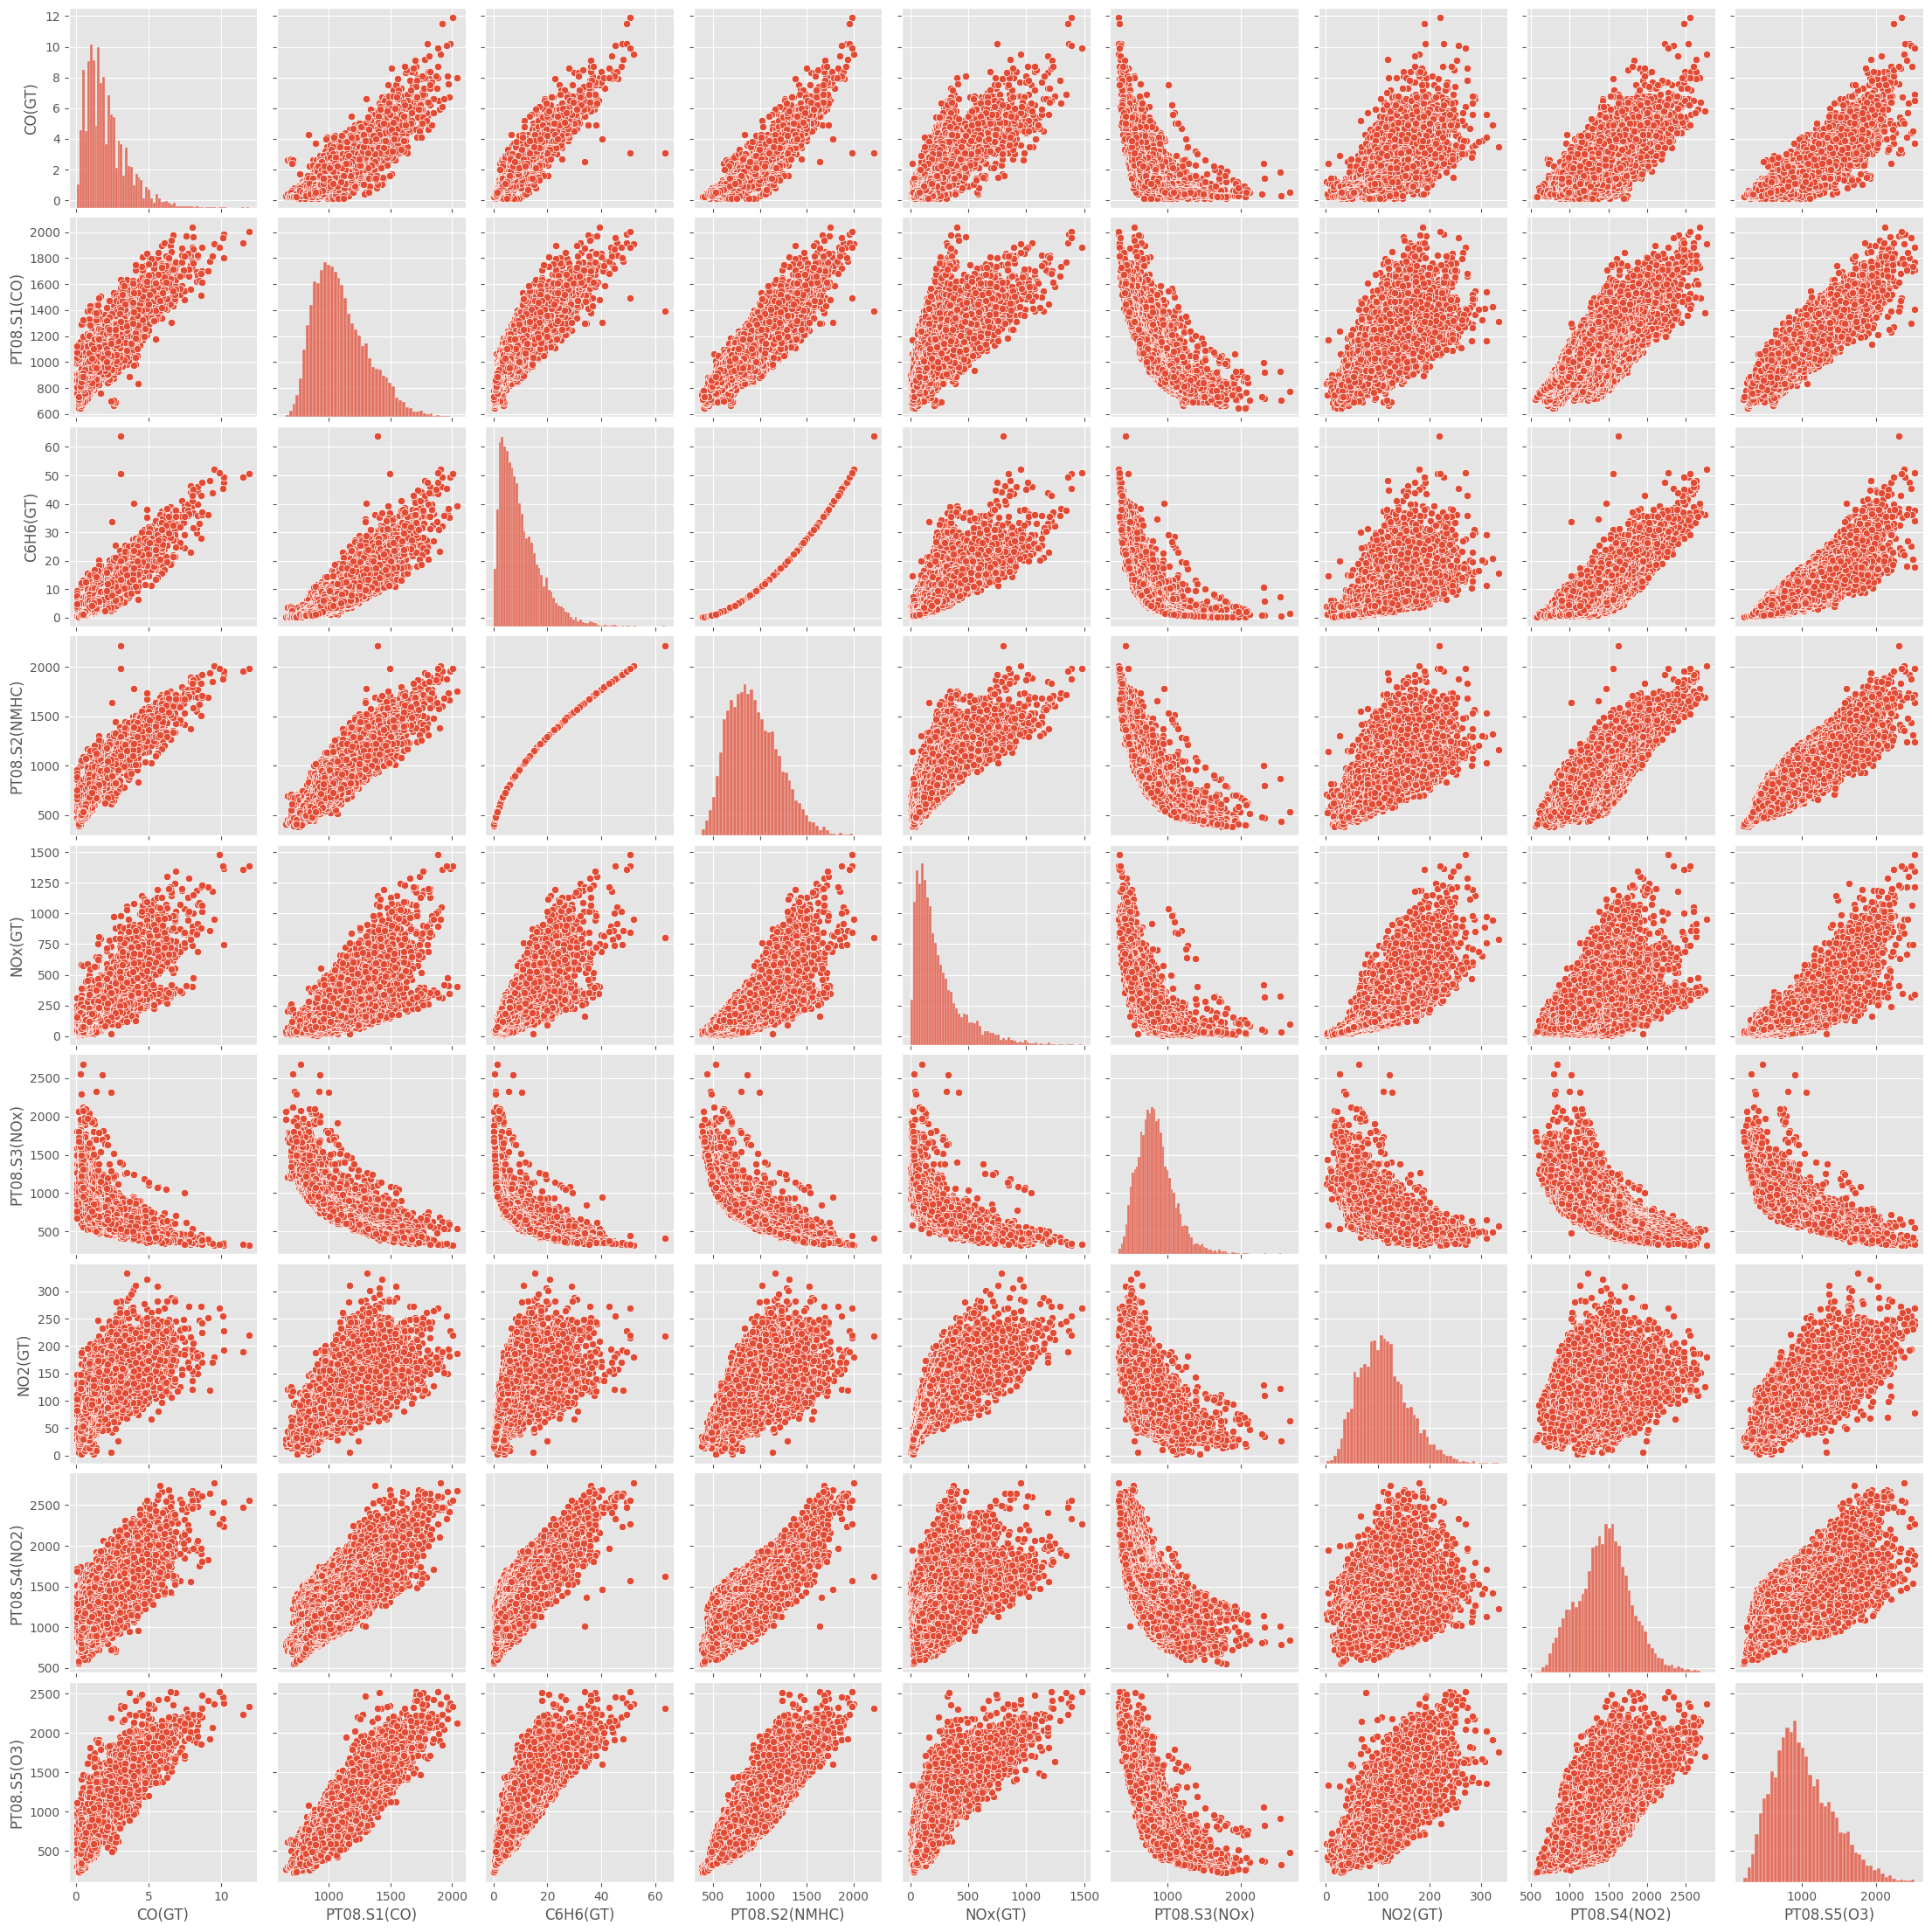

In [ ]:
# Visualize the relationship between variables
sns.pairplot(df_top_corr);

Among all the correlations we can see strongly positively correlated pair: our target and PT08.S2(NMHC).\
On the plot below we can see how their relationship fits a linear regression.

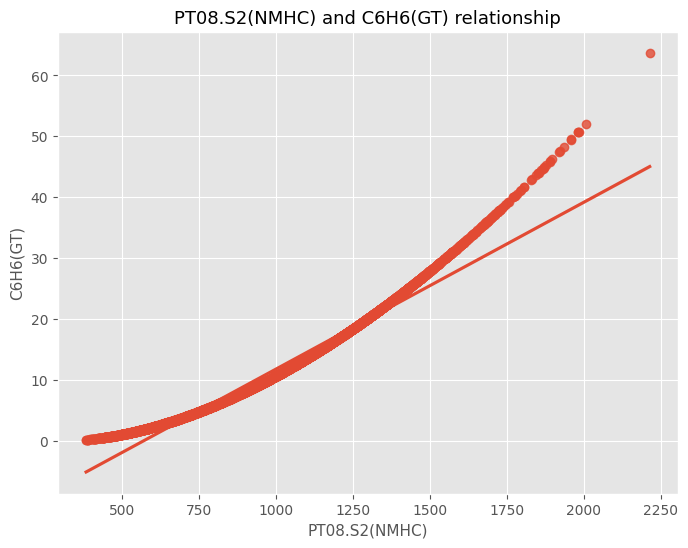

In [ ]:
ax = sns.regplot(x='PT08.S2(NMHC)', y='C6H6(GT)', data=df)
ax.set_title('PT08.S2(NMHC) and C6H6(GT) relationship', fontsize=13)
ax.set_xlabel('PT08.S2(NMHC)', fontsize=11);
ax.set_ylabel('C6H6(GT)', fontsize=11);

The line looks like a section of a parabola.

### Univariate Analysis

#### Target variable analysis

Target variable have to be transformed in order to fit the normal distribution. It is a necessary condition for further analysis of residuals that tells us how good our model fits the data.

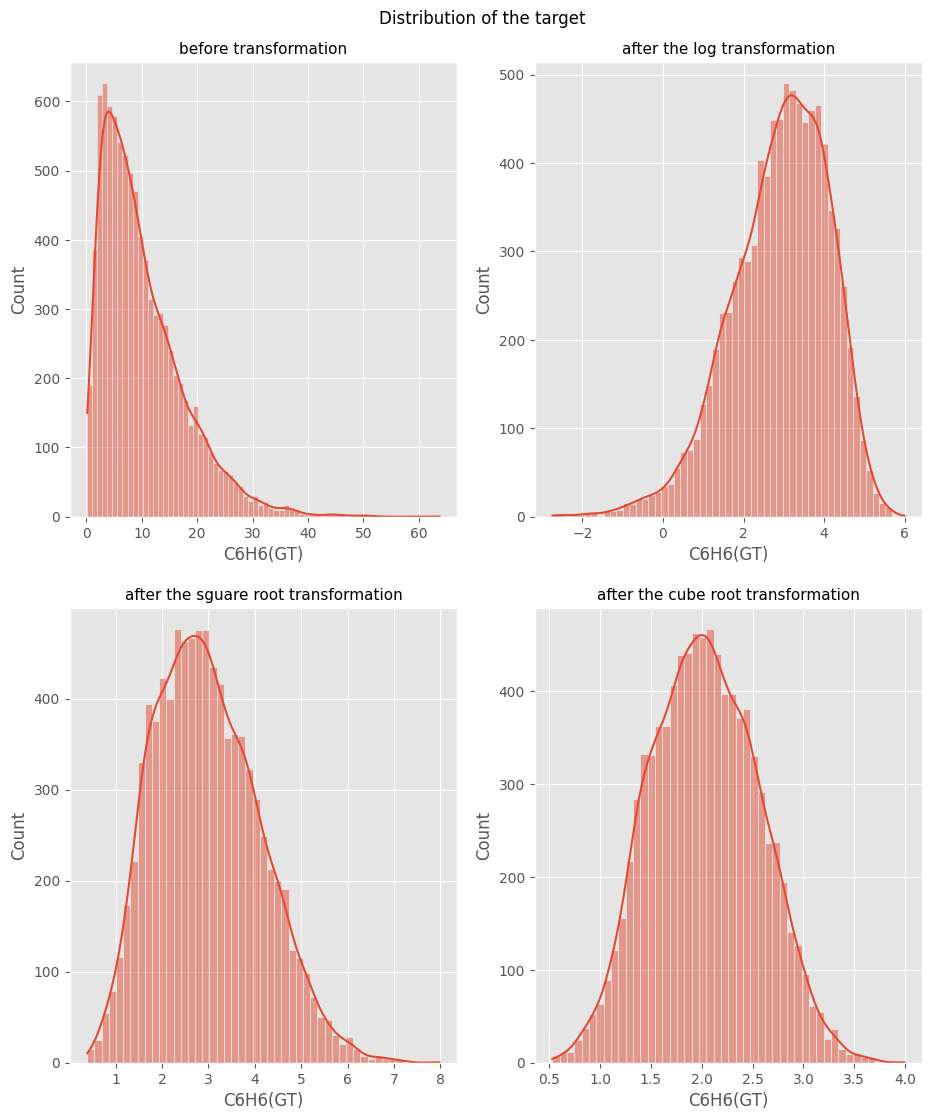

In [ ]:
# Define a number of subplots and a title
fig, axes = plt.subplots(2, 2, figsize=(11, 13))
fig.suptitle('Distribution of the target', y=0.92)

# Plot distribution of the target before transformation
sns.histplot(data=df, x=df['C6H6(GT)'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('before transformation', fontsize=11)

# Plot distribution of the target after the log transformation
sns.histplot(data=df, x=np.log2(df['C6H6(GT)']), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('after the log transformation', fontsize=11)

# Plot distribution of the target after the sguare root transformation
sns.histplot(data=df, x=np.sqrt(df['C6H6(GT)']), kde=True, ax=axes[1, 0],)
axes[1, 0].set_title('after the sguare root transformation', fontsize=11)

# Plot distribution of the target after the cube root transformation
sns.histplot(data=df, x=np.cbrt(df['C6H6(GT)']), kde=True, ax=axes[1, 1])
axes[1, 1].set_title('after the cube root transformation', fontsize=11);

Cube root tranformation suits best for the target transformation to get it normally distributed.

#### Outlier analysis

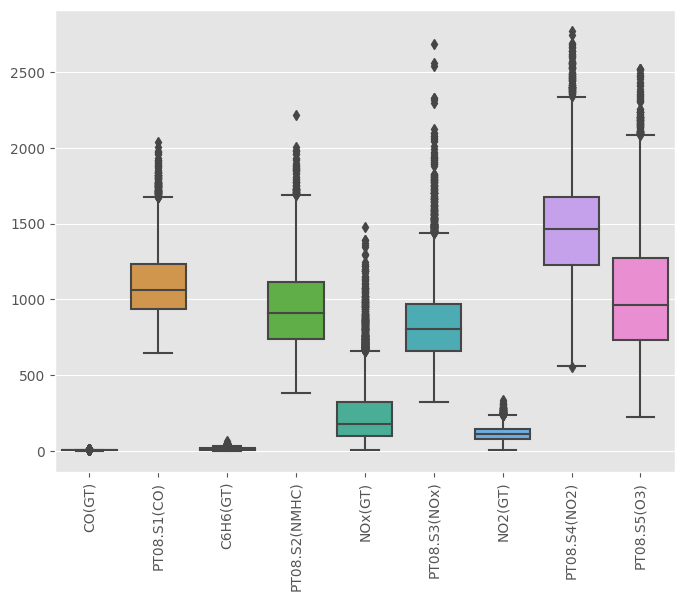

In [ ]:
# Plot boxplots of highly correlated variables to check for outliers
ax = sns.boxplot(data=df_top_corr)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

A lot of variables have outliers.\
To closer look at skewness of variables let's plot histograms.

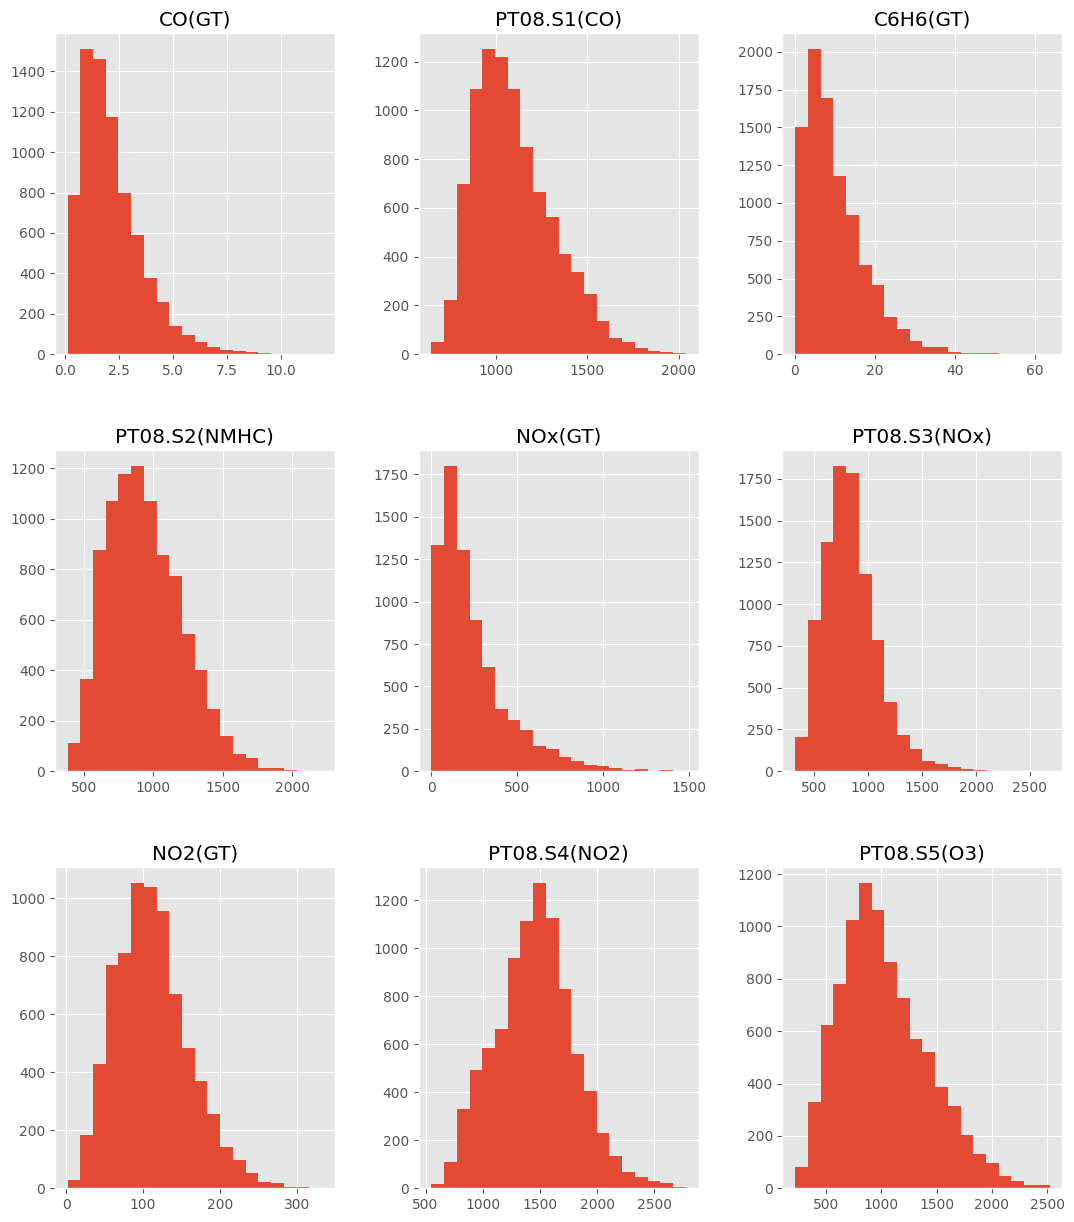

In [ ]:
# Plot histogram of highly correlated variables
df_top_corr.hist(figsize=(13, 15), bins=20);

Although the data set has a lot of values that are statistically outliers, those values are data from real life that tell us about a high level of pollution. I think we shouldn't remove them.

## Modeling and Training

### NN with unscaled data

#### Train/Test Split and X/y Split

In [ ]:
# Remove variables that have low correlation with a target, split into input and output columns
X, y = df.drop(['T', 'AH', 'RH', 'C6H6(GT)'], axis=1), df['C6H6(GT)']

In [ ]:
# Split into train, validation, and test datasets
n = len(df)
X_train, y_train = X[0:int(n*0.8)], y[0:int(n*0.8)]
X_test, y_test = X[int(n*0.8):], y[int(n*0.8):]

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7192, 8), (7192,), (1799, 8), (1799,))

#### Modeling and Training

In [ ]:
# Determine the number of input features
num_features = X_train.shape[1]
num_features

8

In [ ]:
# Define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(num_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1)) #no activation funciton to keep linearity

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "LinReg_weights.hdf5", verbose = 1, save_best_only = True)

In [ ]:
# Fit the model
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), \
                    epochs=100, batch_size=32, verbose=0, callbacks=[checkpointer])


Epoch 1: val_loss did not improve from inf

Epoch 2: val_loss did not improve from inf

Epoch 3: val_loss did not improve from inf

Epoch 4: val_loss did not improve from inf

Epoch 5: val_loss did not improve from inf

Epoch 6: val_loss did not improve from inf

Epoch 7: val_loss did not improve from inf

Epoch 8: val_loss did not improve from inf

Epoch 9: val_loss did not improve from inf

Epoch 10: val_loss did not improve from inf

Epoch 11: val_loss did not improve from inf

Epoch 12: val_loss did not improve from inf

Epoch 13: val_loss did not improve from inf

Epoch 14: val_loss did not improve from inf

Epoch 15: val_loss did not improve from inf

Epoch 16: val_loss did not improve from inf

Epoch 17: val_loss did not improve from inf

Epoch 18: val_loss did not improve from inf

Epoch 19: val_loss did not improve from inf

Epoch 20: val_loss did not improve from inf

Epoch 21: val_loss did not improve from inf

Epoch 22: val_loss did not improve from inf

Epoch 23: val_loss

In the logs we can see that `val_loss did not improve from inf`. Apparantely it happens because data is not scale that's why parameters have diverged while training.

### NN with scaled data

#### Train/Test Split and X/y split

In [ ]:
# Remove variables that have low correlation with a target, split into input and output columns
X, y = df_scaling.drop(['T', 'AH', 'RH', 'C6H6(GT)'], axis=1), df_scaling['C6H6(GT)']

In [ ]:
# Split into train and test data sets
n = len(df_scaling)
X_train, y_train = X[0:int(n*0.8)], y[0:int(n*0.8)]
X_test, y_test = X[int(n*0.8):], y[int(n*0.8):]

In [ ]:
# Check shape of train and test subsets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7192, 9), (7192,), (1799, 9), (1799,))

We should transform a target variable to cube root of it to have a predictand normally distributed. Linearizing the target allows obtaining better prediction.

In [ ]:
y_train_cbrt = pd.Series(np.cbrt(y_train))
y_test_cbrt = pd.Series(np.cbrt(y_test))

#### Scaling

`month`, `day`, and `hour` features are cyclical. Let's extract them and normalize in a different way than other variables.

In [ ]:
# Extract cyclical features from a train subset
X_train['month'] = X_train.DateTime.dt.month
X_train['day'] = X_train.DateTime.dt.day
X_train['hour'] = X_train.DateTime.dt.hour

In [ ]:
# Extract cyclical features from a test subset
X_test['month'] = X_test.DateTime.dt.month
X_test['day'] = X_test.DateTime.dt.day
X_test['hour'] = X_test.DateTime.dt.hour

In [ ]:
# Apply a sine and cosine transformtaion for the hourly, daily, and monthly data of a train subset
X_train = encode(X_train, 'month', 12)
X_train = encode(X_train, 'day', 31)
X_train = encode(X_train, 'hour', 24)

In [ ]:
# Apply a sine and cosine transformtaion for the hourly, daily, and monthly data of a train subset
X_test = encode(X_test, 'month', 12)
X_test = encode(X_test, 'day', 31)
X_test = encode(X_test, 'hour', 24)

In [ ]:
# Drop 'hour', 'day', 'month' columns since now we have columns with their scaled values
X_train = X_train.drop(['hour', 'day', 'month'], axis=1)
X_test = X_test.drop(['hour', 'day', 'month'], axis=1)

In [ ]:
# Make a Date column an index to later fill NAs and divide the dataset as TimeSeries
X_train.set_index('DateTime', inplace=True)
X_test.set_index('DateTime', inplace=True)

In [ ]:
# Fill NAs with an interpolation method
X_train = X_train.interpolate(method='time')
X_test = X_test.interpolate(method='time')

Since there are outliers in the data set we should scale data with method that is not sensitive to outliers (for example, RobustScaler). But let's conduct an experiment to choose an appropriate scaler. Question is: what scaler allows preserving a strong linear correlation between a target and the most correlated with it variable.

In [ ]:
# Scaling a train subset with three different scalers
X_train_robust = pd.DataFrame(RobustScaler().fit_transform(X_train),
                              columns=X_train.columns)

X_train_standard = pd.DataFrame(StandardScaler().fit_transform(X_train),
                              columns=X_train.columns)

X_train_minmax = pd.DataFrame(MinMaxScaler().fit_transform(X_train),
                              columns=X_train.columns)

Let's plot relationship of a target with the strongest correlated variable scaled by different scalers.

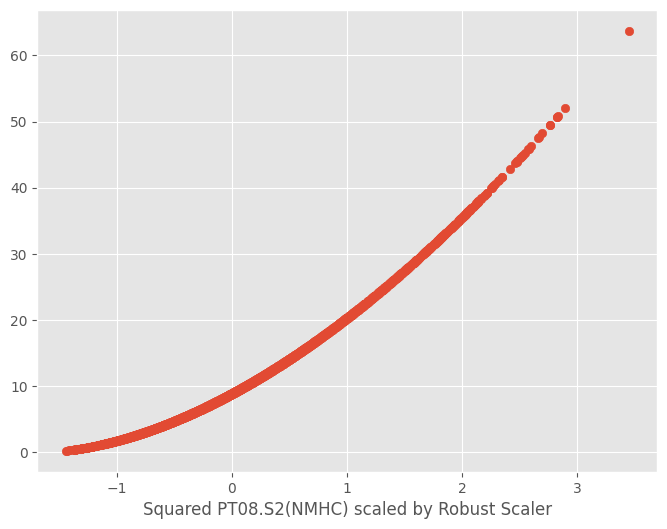

In [ ]:
plt.scatter(x = (X_train_robust['PT08.S2(NMHC)']), y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by Robust Scaler');

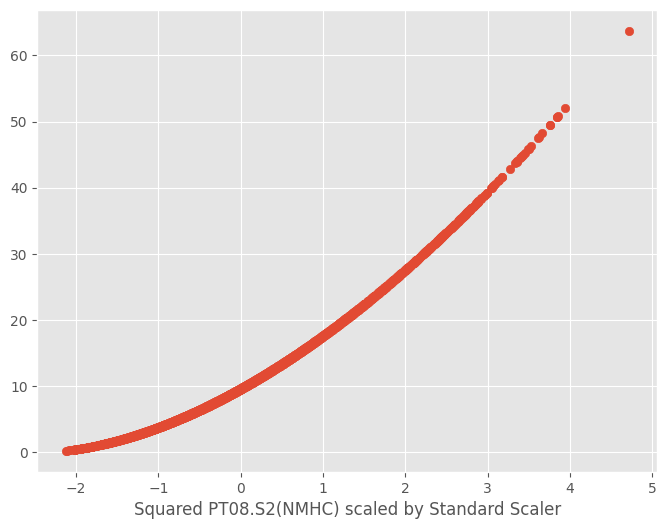

In [ ]:
plt.scatter(x = (X_train_standard['PT08.S2(NMHC)']), y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by Standard Scaler');

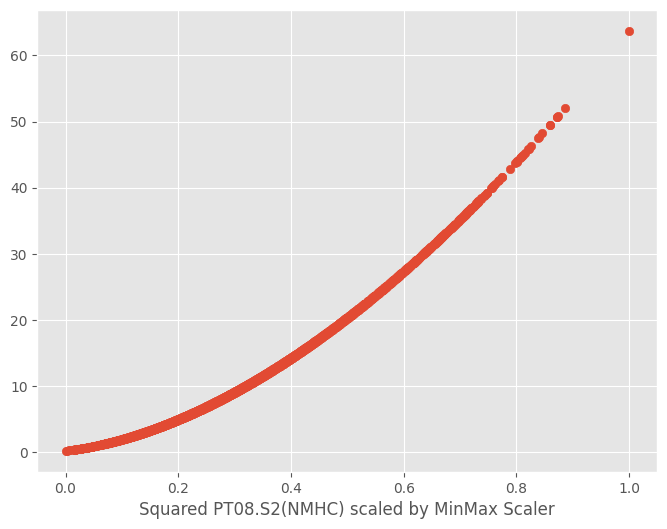

In [ ]:
plt.scatter(x = (X_train_minmax['PT08.S2(NMHC)']), y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by MinMax Scaler');

No difference. But what if we try to make our line straight and square a variable.

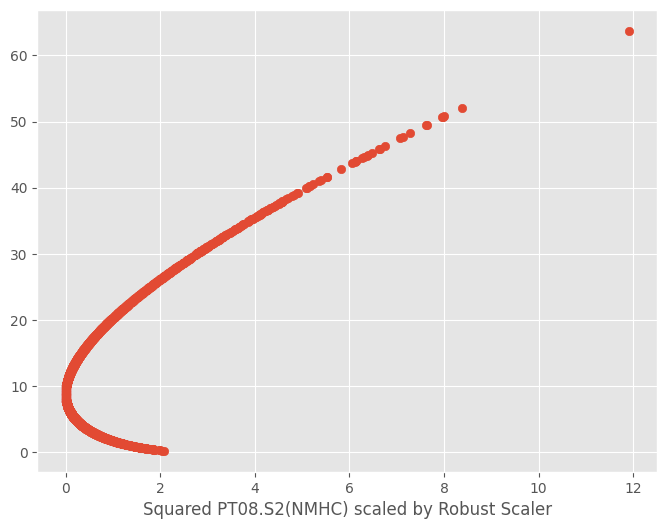

In [ ]:
plt.scatter(x = (X_train_robust['PT08.S2(NMHC)'])**2, y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by Robust Scaler');

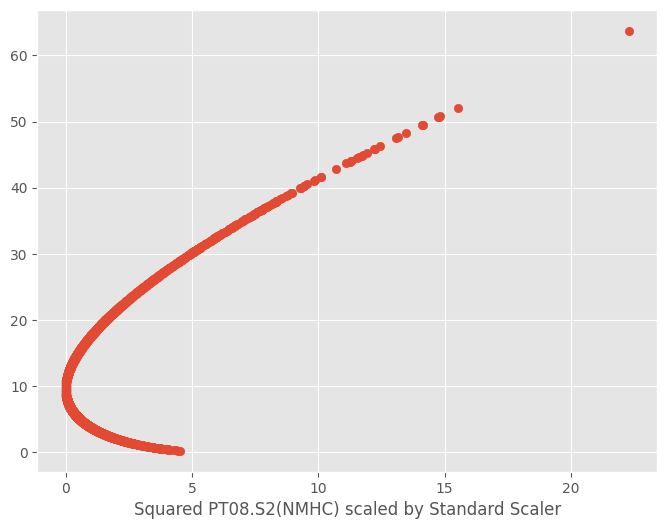

In [ ]:
plt.scatter(x = (X_train_standard['PT08.S2(NMHC)'])**2, y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by Standard Scaler');

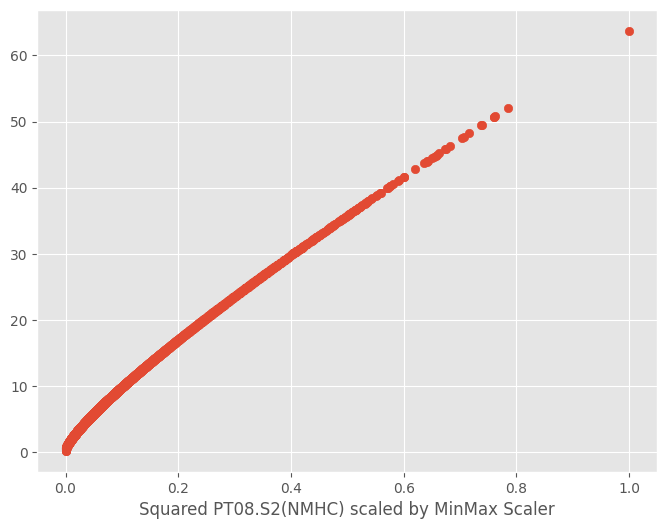

In [ ]:
plt.scatter(x = (X_train_minmax['PT08.S2(NMHC)'])**2, y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by MinMax Scaler');

MinMax Scaler happened to be the most efficient scaler.

In [ ]:
minmax_scaler = MinMaxScaler()

X_train_minmax = pd.DataFrame(minmax_scaler.fit_transform(X_train),
                              columns=X_train.columns)
X_test_minmax = pd.DataFrame(minmax_scaler.transform(X_test),
                              columns=X_test.columns)

In [ ]:
# Determine the number of input features
num_features = X_train_minmax.shape[1]
num_features

14

#### Modeling and Training

In [ ]:
# Define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(num_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1)) #no activation funciton to keep linearity

In [ ]:
# Show how many layers and parameters the model has
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 10)                150       
                                                                 
 dense_157 (Dense)           (None, 8)                 88        
                                                                 
 dense_158 (Dense)           (None, 1)                 9         
                                                                 
Total params: 247
Trainable params: 247
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.3)

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "LinReg_weights.hdf5", verbose = 1, save_best_only = True)

In [ ]:
# Fit the model
%%time
history = model.fit(X_train_minmax, y_train_cbrt, validation_data=(X_test_minmax, y_test_cbrt), \
                    epochs=150, batch_size=32, verbose=0, callbacks=[checkpointer])


Epoch 1: val_loss improved from inf to 0.26411, saving model to LinReg_weights.hdf5

Epoch 2: val_loss improved from 0.26411 to 0.14850, saving model to LinReg_weights.hdf5

Epoch 3: val_loss improved from 0.14850 to 0.06602, saving model to LinReg_weights.hdf5

Epoch 4: val_loss improved from 0.06602 to 0.03893, saving model to LinReg_weights.hdf5

Epoch 5: val_loss improved from 0.03893 to 0.02550, saving model to LinReg_weights.hdf5

Epoch 6: val_loss improved from 0.02550 to 0.01564, saving model to LinReg_weights.hdf5

Epoch 7: val_loss improved from 0.01564 to 0.01311, saving model to LinReg_weights.hdf5

Epoch 8: val_loss improved from 0.01311 to 0.01220, saving model to LinReg_weights.hdf5

Epoch 9: val_loss improved from 0.01220 to 0.00990, saving model to LinReg_weights.hdf5

Epoch 10: val_loss improved from 0.00990 to 0.00827, saving model to LinReg_weights.hdf5

Epoch 11: val_loss improved from 0.00827 to 0.00665, saving model to LinReg_weights.hdf5

Epoch 12: val_loss did

In [ ]:
# Save the model architecture to json file for futher use
model_json = model.to_json()
with open("LinReg_model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
with open('LinReg_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model architecture
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('LinReg_weights.hdf5')

adam = tf.keras.optimizers.Adam(learning_rate=0.3)

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# Evaluate the model
metrics = model.evaluate(X_test_minmax, y_test_cbrt, verbose=0)
print('MSE: %.6f' % (metrics[0]))
print('RMSE: %.6f' % (metrics[1]))

MSE: 0.000121
RMSE: 0.010987


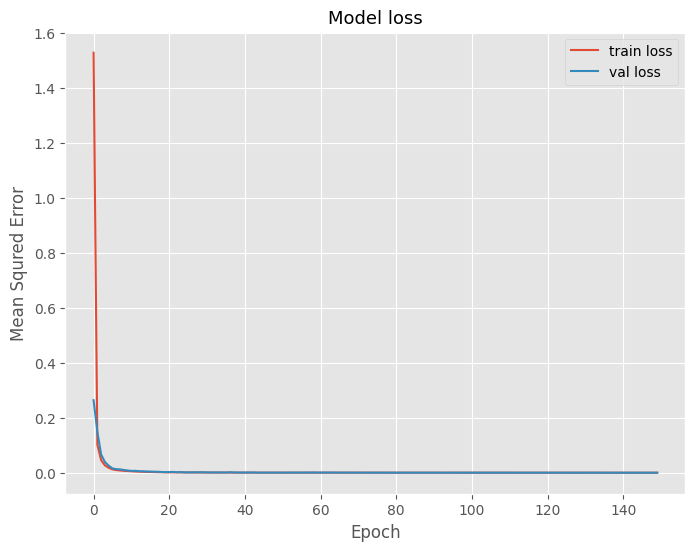

In [ ]:
# Plot a learning curve (change of loss during training)
plt.title('Model loss', fontsize=13)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squred Error', fontsize=12)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
# Calculate test predictions and errors
test_pred = model.predict(X_test_minmax).flatten()
errors = y_test_cbrt - np.cbrt(test_pred)

57/57 [==============================] - 0s 1ms/step


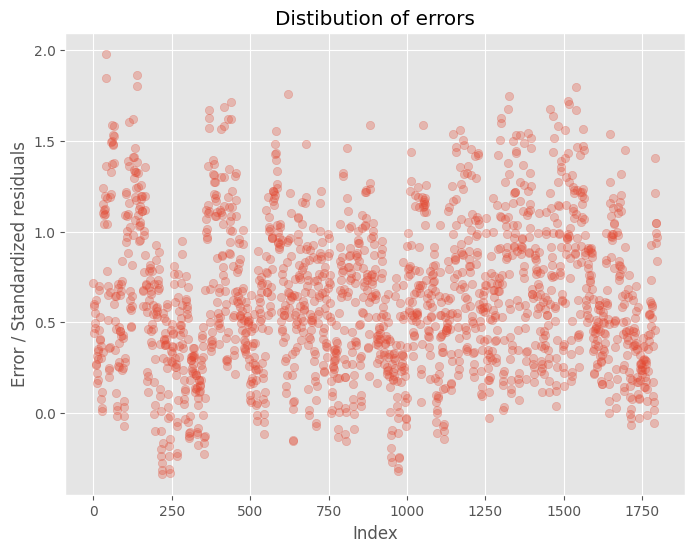

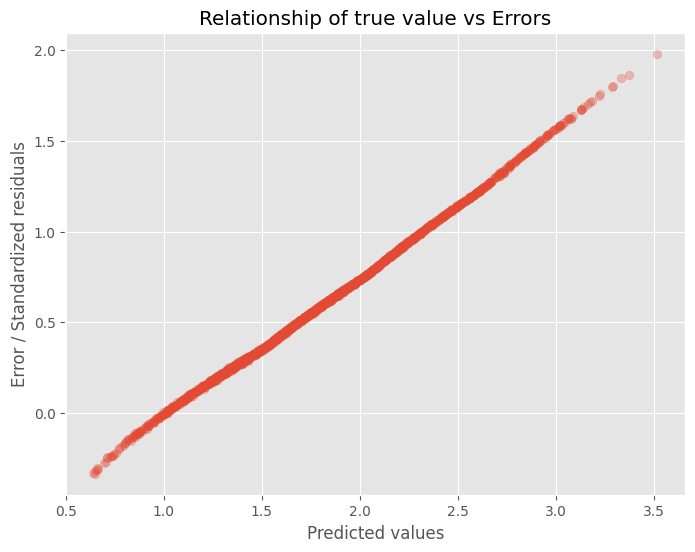

In [ ]:
plt.scatter(list(range(len(errors))),errors, alpha = 0.3);
plt.title("Distibution of errors")
plt.ylabel('Error / Standardized residuals');
plt.xlabel('Index');
plt.show();

plt.scatter(test_pred, errors, alpha = 0.3);
plt.title('Relationship of true value vs Errors')
plt.ylabel('Error / Standardized residuals');
plt.xlabel('Predicted values');
plt.show();

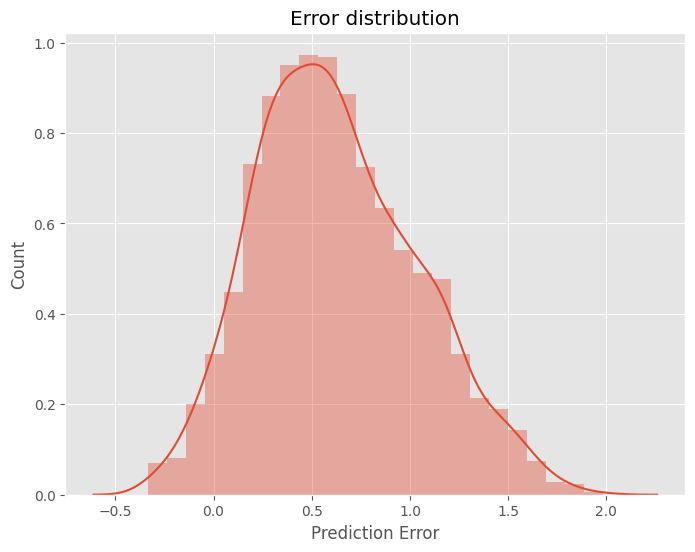

In [ ]:
# Plot error distribution
ax = sns.distplot(errors, norm_hist=True)
ax.set_title('Error distribution');
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count');

Comparing a linear regression model from Machine Learning module [homework](https://colab.research.google.com/drive/1cyJYR5FCOy4OeD0nqeXdMFpti9cXSLDU#scrollTo=od1yDBTZSF2v) to a neural network model we can see that the latter gave even a better result than the second-degree polynomial regression model. So we can conclude that a neural network model can be an alternative to a polynomial regression model (that is proved in academic papers).

Let's improve the model.

#### Model tuning

In [ ]:
# Define model
model = Sequential()
model.add(Dense(12, activation='relu', kernel_initializer='he_normal', input_shape=(num_features,)))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))  #no activation funciton to keep linearity

In [ ]:
# Show how many layers and parameters the model has
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_163 (Dense)           (None, 10)                150       
                                                                 
 dense_164 (Dense)           (None, 8)                 88        
                                                                 
 dense_165 (Dense)           (None, 6)                 54        
                                                                 
 dense_166 (Dense)           (None, 1)                 7         
                                                                 
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define optimizer, compile the model
adam = tf.keras.optimizers.Adam(learning_rate=1)

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "LinReg2_weights.hdf5", verbose = 1, save_best_only = True)

In [ ]:
# Fit the model
%%time
history = model.fit(X_train_minmax, y_train_cbrt,
                    validation_data=(X_test_minmax, y_test_cbrt),
                    epochs=150, batch_size=32, verbose=0,
                    callbacks=[checkpointer])


Epoch 1: val_loss improved from inf to 0.18122, saving model to LinReg2_weights.hdf5

Epoch 2: val_loss improved from 0.18122 to 0.07129, saving model to LinReg2_weights.hdf5

Epoch 3: val_loss improved from 0.07129 to 0.03785, saving model to LinReg2_weights.hdf5

Epoch 4: val_loss improved from 0.03785 to 0.02439, saving model to LinReg2_weights.hdf5

Epoch 5: val_loss improved from 0.02439 to 0.01905, saving model to LinReg2_weights.hdf5

Epoch 6: val_loss improved from 0.01905 to 0.01560, saving model to LinReg2_weights.hdf5

Epoch 7: val_loss improved from 0.01560 to 0.01359, saving model to LinReg2_weights.hdf5

Epoch 8: val_loss improved from 0.01359 to 0.01191, saving model to LinReg2_weights.hdf5

Epoch 9: val_loss improved from 0.01191 to 0.01080, saving model to LinReg2_weights.hdf5

Epoch 10: val_loss improved from 0.01080 to 0.00890, saving model to LinReg2_weights.hdf5

Epoch 11: val_loss improved from 0.00890 to 0.00654, saving model to LinReg2_weights.hdf5

Epoch 12: v

In [ ]:
# Save the model architecture to json file for futher use
model_json = model.to_json()
with open("LinReg_model2.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
with open('LinReg_model2.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model architecture
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('LinReg2_weights.hdf5')

adam = tf.keras.optimizers.Adam(learning_rate=1)

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# Evaluate the model
metrics = model.evaluate(X_test_minmax, y_test_cbrt, verbose=0)
print('MSE: %.6f' % (metrics[0]))
print('RMSE: %.6f' % (metrics[1]))

MSE: 0.000053
RMSE: 0.007279


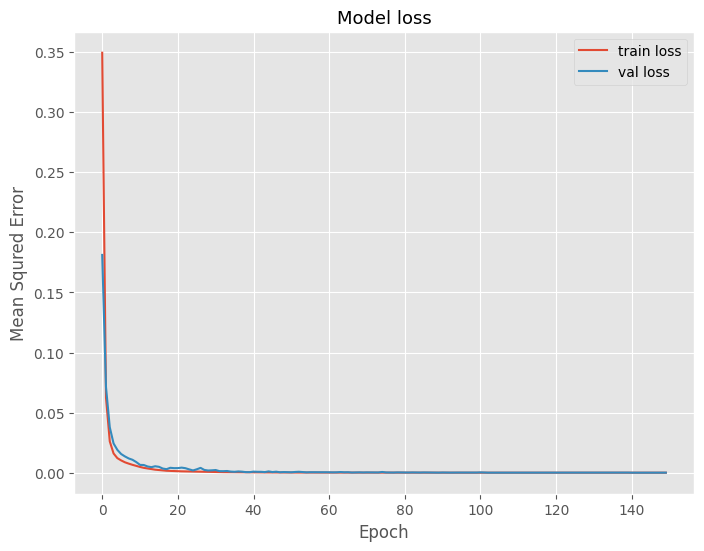

In [ ]:
# Plot loss during training
plt.title('Model loss', fontsize=13)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squred Error', fontsize=12)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
# Calculate test predictions and errors
test_pred = model.predict(X_test_minmax).flatten()
errors = y_test_cbrt - np.cbrt(test_pred)

57/57 [==============================] - 0s 1ms/step


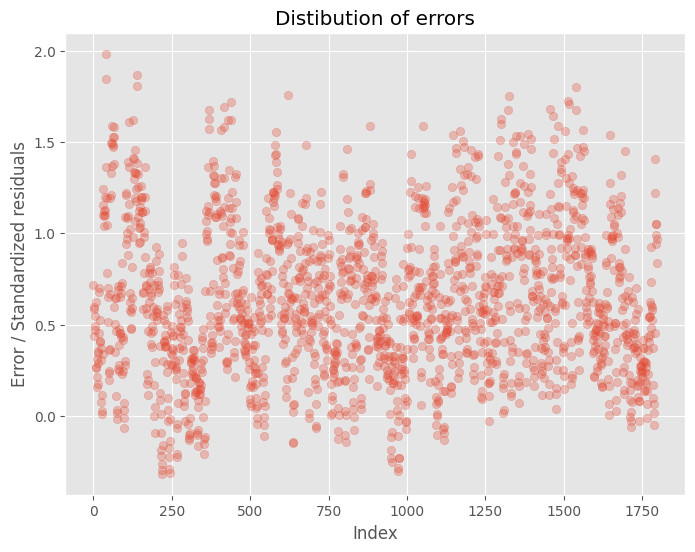

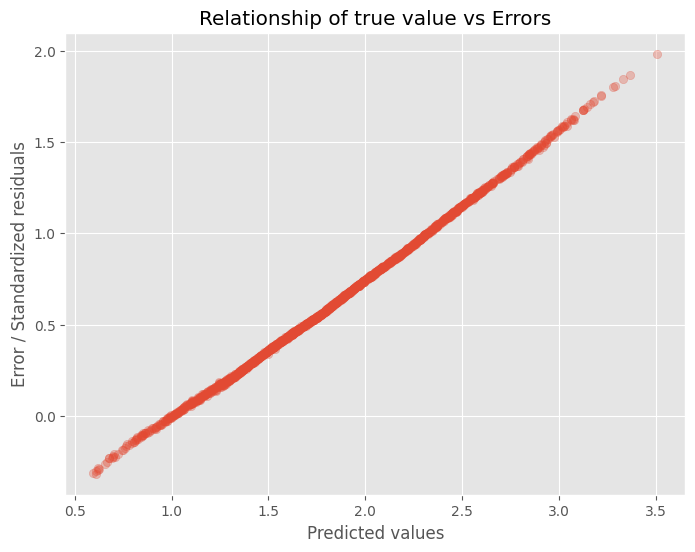

In [ ]:
plt.scatter(list(range(len(errors))),errors, alpha = 0.3);
plt.title("Distibution of errors")
plt.ylabel('Error / Standardized residuals');
plt.xlabel('Index');
plt.show();

plt.scatter(test_pred, errors, alpha = 0.3);
plt.title('Relationship of true value vs Errors')
plt.ylabel('Error / Standardized residuals');
plt.xlabel('Predicted values');
plt.show();

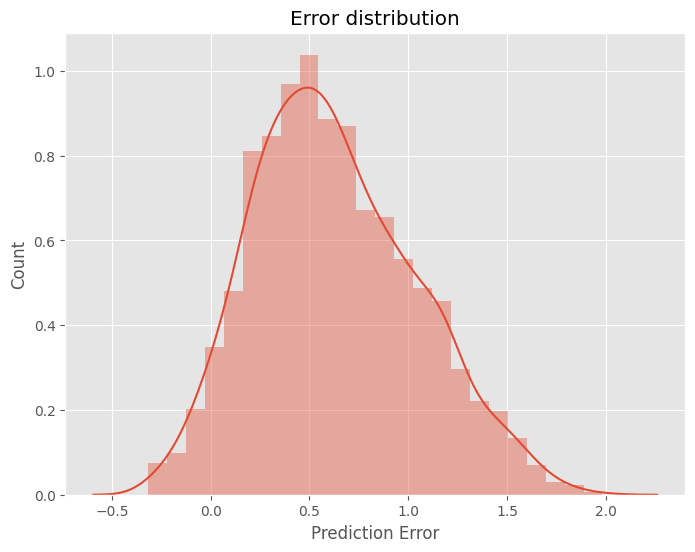

In [ ]:
# Plot error distribution
ax = sns.distplot(errors, norm_hist=True)
ax.set_title('Error distribution');
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count');

We got a much better RMSE, the same as one of a third-degree polynomial regression model, having reduced a learning rate, increased the number of neurons and added a hidden layer.